In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal
from sklearn.linear_model import LinearRegression

$$\mathrm{A \underset{Ni}{\overset{k_1}{\longrightarrow}} B + C}$$

$$r = k_1 \theta_A = k_1\frac{aA}{1 + aA + bB + cC}$$

$$r = \frac{1}{V}\frac{\mathrm{d}\xi}{\mathrm{d}t} \simeq k_1\frac{aA}{aA + bB} = k\frac{a(n_0 - \xi)}{a(n_0 - \xi) + b\xi}$$

$$\int\limits_0^\xi\left(1 + \frac{b\xi}{a(n_0-\xi)}\right)\mathrm{d}\xi = \int\limits_0^t k_1V\mathrm{d}t$$

$$\left(1 - \frac{b}{a}\right)\xi - n_0\frac{b}{a}\ln\left|\frac{n_0 - \xi}{n_0}\right| = k_1Vt$$

$$ t(\xi) = \frac{1}{k_1}(1-k_2) \frac{\xi}{V} + \frac{k_2}{k_1}\left(-\frac{n_0}{V}\right)\ln\left|\frac{n_0 - \xi}{n_0}\right| = c_1 x_1(\xi) + c_2 x_2(\xi)$$

$$k_1 = \frac{1}{c_1 + c_2} \,,\quad k_2 = \frac{c_2}{c_1 + c_2}$$

$$r = k_1\frac{aA}{aA + bB} \rightarrow \frac{1}{r} = \frac{1}{k_1}\left(1 + k_2 \frac{\xi}{n_0 - \xi}\right) $$

In [2]:
df = pd.read_excel("cathet.xlsx")

In [3]:
df = df.loc[2:]

In [4]:
df["t"] = df["t"] - df.loc[2, "t"]
df["V"] = df["V"] - df.loc[2, "V"]

In [5]:
df[:5]

,t,V
2,0,0.000000
3,39,0.000008
4,131,0.000027
5,184,0.000038
6,214,0.000044


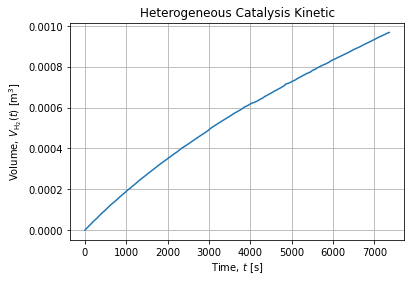

In [6]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["V"])
axe.set_title("Heterogeneous Catalysis Kinetic")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel("Volume, $V_\mathrm{H_2}(t)$ $[\mathrm{m^3}]$")
axe.grid()

In [7]:
R = 8.31446261815324  # J/mol.K
T0 = 292.05           # K
p0 = 101600           # Pa
V = 190e-6            # m3 of isopropanol
m = 2.7677            # g of Raney Nickel
rho = 785             # kg/m³
M = 60.1              # g/mol
n0 = 1000*rho*V/M     # mol

In [8]:
n0

2.4816971713810316

In [9]:
df["xi"] = p0*df["V"]/(R*T0)
df["B/A"] = df["xi"]/(n0 - df["xi"])
df["x1"] = df["xi"]/V
df["x2"] = -(n0/V)*np.log(np.abs((n0 - df["xi"])/n0))
df["dxidt1"] = df["xi"].diff()/df["t"].diff()
df["1/r1"] = 1./df["dxidt1"]

In [10]:
df

,t,V,xi,B/A,x1,x2,dxidt1,1/r1
2,0,0.000000,0.000000,0.000000,0.000000,-0.000000,NaN,NaN
3,39,0.000008,0.000339,0.000137,1.783749,1.783871,0.000009,115074.017568
4,131,0.000027,0.001126,0.000454,5.923808,5.925152,0.000009,116957.389377
5,184,0.000038,0.001603,0.000646,8.434270,8.436994,0.000009,111113.980526
6,214,0.000044,0.001845,0.000744,9.711522,9.715134,0.000008,123620.628952
...,...,...,...,...,...,...,...,...
113,6938,0.000927,0.038791,0.015879,204.162179,205.774609,0.000004,233441.745835
114,7088,0.000943,0.039439,0.016149,207.575526,209.242616,0.000004,231290.209007
115,7272,0.000960,0.040172,0.016453,211.429304,213.159215,0.000004,251291.305177
116,7300,0.000964,0.040314,0.016513,212.178039,213.920291,0.000005,196823.432763


In [11]:
X = df[["x1", "x2"]].values
y = df["t"].values

In [12]:
regressor = LinearRegression().fit(X, y)
regressor.score(X, y)

0.9999563894349557

In [13]:
regressor.coef_

array([-1643.83116631,  1664.63643311])

In [14]:
yhat = regressor.predict(X)

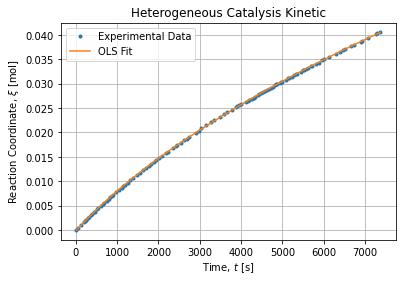

In [15]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["xi"], ".", label="Experimental Data")
axe.plot(yhat, df["xi"], "-", label="OLS Fit")
axe.set_title("Heterogeneous Catalysis Kinetic")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [16]:
def solve(c1, c2):
    k1 = 1./(c1 + c2)
    k2 = c2*k1
    return k1, k2

In [17]:
k1, k2 = solve(*regressor.coef_)
k1, k2

(0.048064752532104564, 80.01033821320921)

In [18]:
k1*V/m # mol/s

3.2996000220760445e-06

In [26]:
X = df[["B/A"]].values[1:]
y = df["1/r1"].values[1:]
regressor = LinearRegression().fit(X, y)
regressor.score(X, y)

0.5651210068486289

In [28]:
regressor.coef_, regressor.intercept_

(array([8758594.37571687]), 111937.88579139842)

In [36]:
Xmax = np.linspace(df["B/A"].min(), df["B/A"].max(), 2).reshape(-1, 1)
yhat = regressor.predict(Xmax)

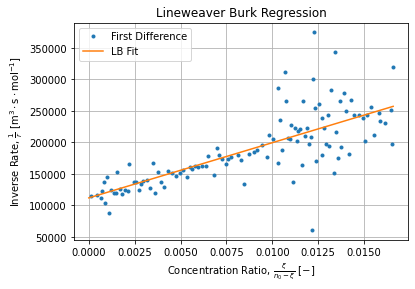

In [40]:
fig, axe = plt.subplots()
axe.plot(df["B/A"], df["1/r1"], ".", label="First Difference")
axe.plot(Xmax, yhat, label="LB Fit")
axe.set_title("Lineweaver Burk Regression")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend()
axe.grid()

In [106]:
k1 = 1/regressor.intercept_
k2 = regressor.coef_[0]/regressor.intercept_
k1, k2

(8.933525882948581e-06, 78.24512955371452)

In [77]:
df["xisg"] = signal.savgol_filter(df["xi"], 21, 5)
df["dxisgdt"] = df["xisg"].diff()/df["t"].diff()

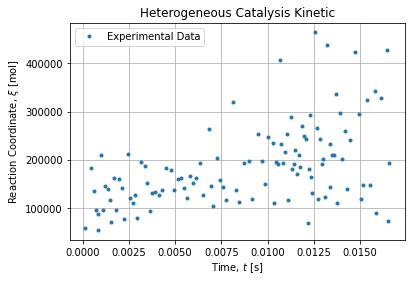

In [79]:
fig, axe = plt.subplots()
axe.plot(df["B/A"], 1/df["dxisgdt"], ".", label="Experimental Data")
axe.set_title("Heterogeneous Catalysis Kinetic")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [83]:
df["ximv"] = df["xi"].rolling(10).mean()
df["dximvdt"] = df["ximv"].diff()/df["t"].diff()

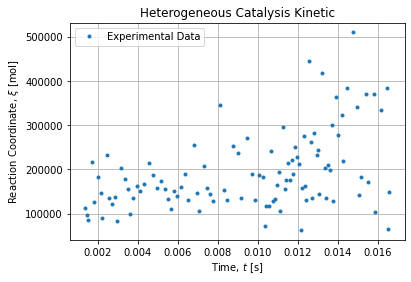

In [84]:
fig, axe = plt.subplots()
axe.plot(df["B/A"], 1/df["dximvdt"], ".", label="Experimental Data")
axe.set_title("Heterogeneous Catalysis Kinetic")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [86]:
def factory(n0, V):
    def wrapped(xi, k1, k2):
        return (1-k2)/k1*(xi/V) - (k2/k1)*(n0/V)*np.log((n0 - xi)/n0)
    return wrapped

In [87]:
objective = factory(n0, V)

In [90]:
parameters, covariance = optimize.curve_fit(objective, df["xi"], df["t"])
parameters, covariance

(array([4.75360716e-02, 7.80055896e+01]),
 array([[1.21265292e-08, 5.87172563e-05],
        [5.87172563e-05, 2.90824476e-01]]))

In [93]:
that = objective(df["xi"], *parameters)

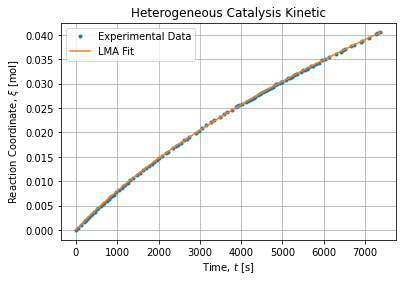

In [94]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["xi"], ".", label="Experimental Data")
axe.plot(that, df["xi"], "-", label="LMA Fit")
axe.set_title("Heterogeneous Catalysis Kinetic")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()